In [1]:
import pandas as pd
import numpy as np
import os as os
import acessos as ac
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

Query

In [15]:
query = """

select date_trunc('month',a.install_time) as mes_instalacao,
count(distinct case when b.nm_media_source_appsflyer_group_big = 'organico' then a.appsflyer_id end) as install_organico,
count(distinct case when b.nm_media_source_appsflyer_group_big = 'ecred' then a.appsflyer_id end) as install_ecred,
count(distinct case when b.nm_media_source_appsflyer_group_big = 'midias sociais' then a.appsflyer_id end) as install_midias_sociais,
count(distinct case when b.nm_media_source_appsflyer_group_big = 'novos canais' then a.appsflyer_id end) as install_novos_canais,
count(distinct case when b.nm_media_source_appsflyer_group_big = 'repescagem' then a.appsflyer_id end) as install_repescagem,
count(distinct case when b.nm_media_source_appsflyer_group_big = 'mgm' then a.appsflyer_id end) as install_mgm
from growth_curated_zone.appsflyer_base_atribuicao a
left join processed_zone_api_cac_planilha.grupo_midia_mkt b 
on lower(a.media_source) = lower(b.nm_media_source_appsflyer)
where row_install_attrib = 1 
and a.install_time >= date('2020-01-01')
and a.install_time < date('2023-11-01')
group by 1
order by 1

"""


In [16]:
df = ac.df_athena('flavia-costa', query)

In [12]:
df.head()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm
0,2020-01-01,3263,0,0,0,42,92
1,2020-02-01,4186,0,0,0,85,97
2,2020-03-01,3996,0,0,0,31,74
3,2020-04-01,2950,0,0,0,14,50
4,2020-05-01,3620,0,0,0,13,78


In [17]:
df.tail()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm
41,2023-06-01,2089680,0,687128,929274,59685,232106
42,2023-07-01,2131860,0,726819,1742269,56535,283708
43,2023-08-01,3057870,1579,729066,1093317,19559,325834
44,2023-09-01,2499799,1575,720318,528864,56711,321516
45,2023-10-01,2998930,14,446929,351228,76841,347058


### Exploração 

Text(0.5, 1.0, 'Instalações organico')

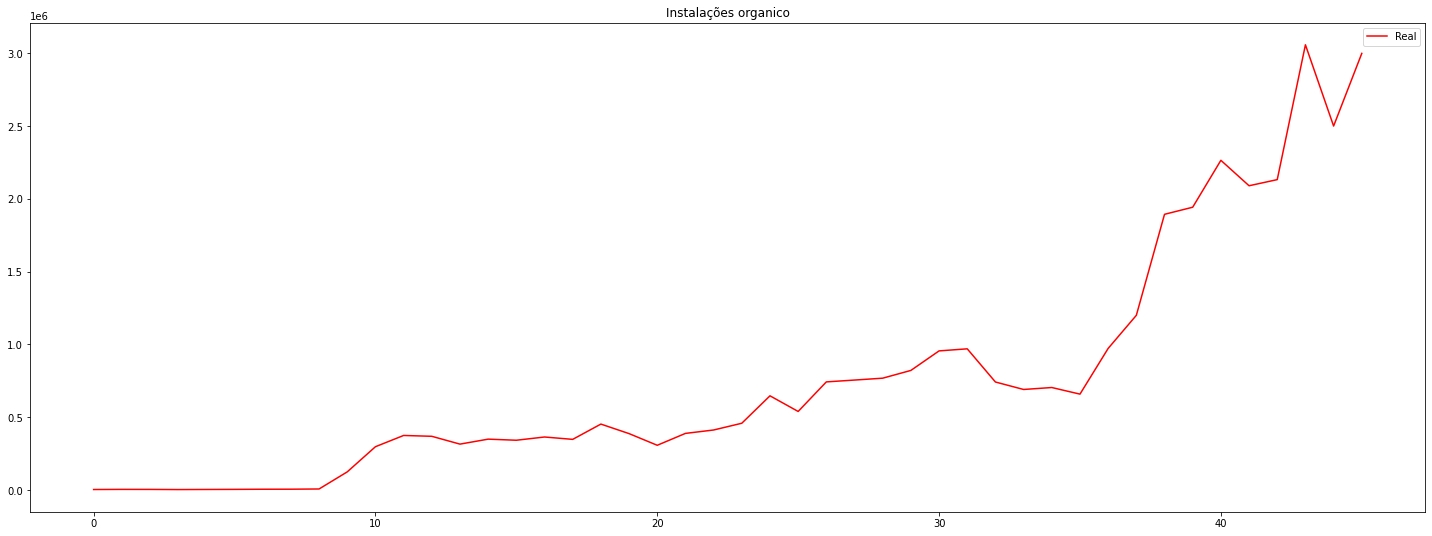

In [18]:
plt.figure(figsize=(25,9))
plt.plot(df['install_organico'], color = 'red', label = 'Real')
plt.legend()
plt.title('Instalações organico')

Text(0.5, 1.0, 'Instalaçoes Mídias Sociais')

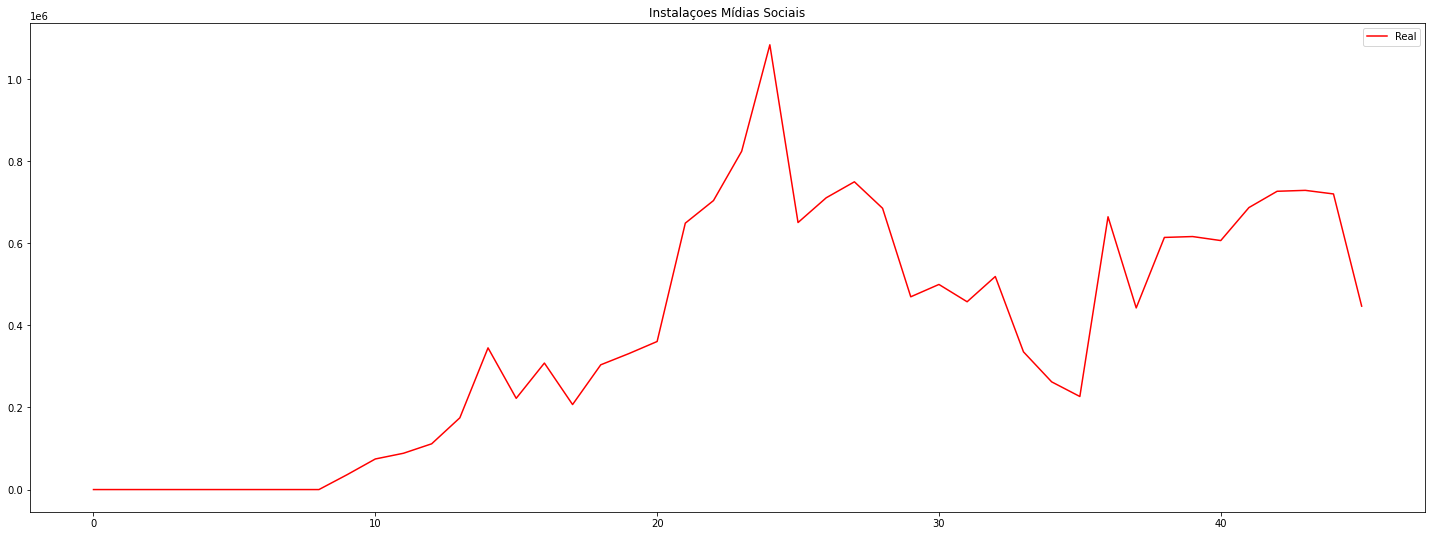

In [19]:
plt.figure(figsize=(25,9))
plt.plot(df['install_midias_sociais'], color = 'red', label = 'Real')
plt.legend()
plt.title('Instalaçoes Mídias Sociais')

Text(0.5, 1.0, 'Instalaçoes MGM')

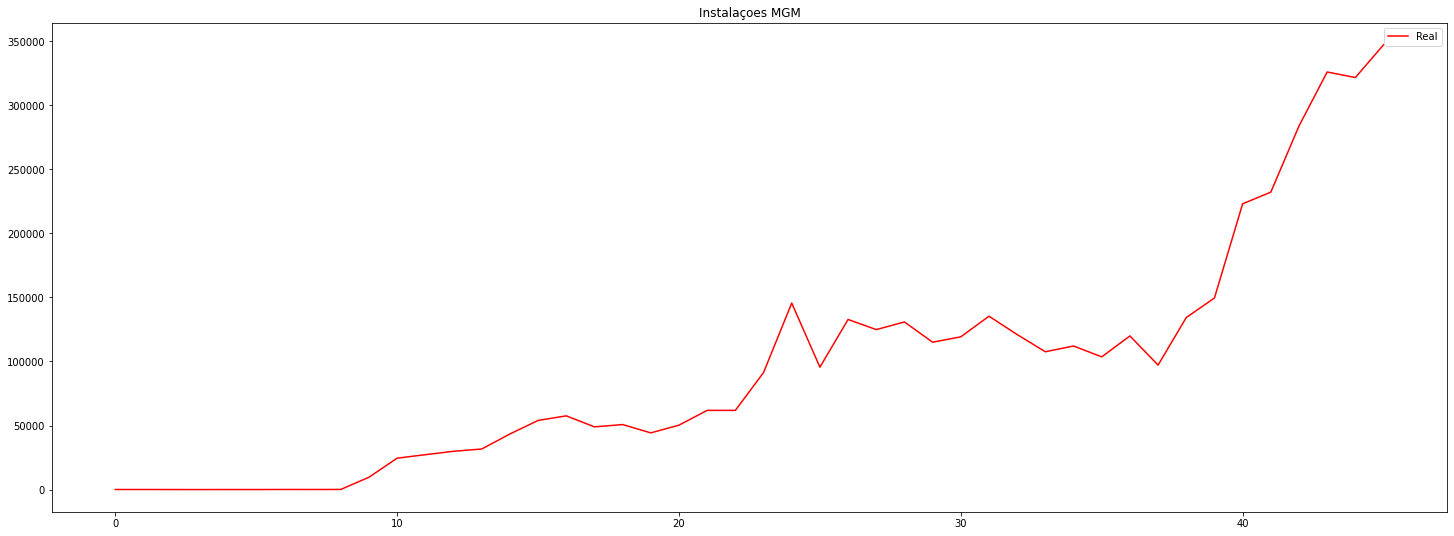

In [20]:
plt.figure(figsize=(25,9))
plt.plot(df['install_mgm'], color = 'red', label = 'Real')
plt.legend()
plt.title('Instalaçoes MGM')

## Correlações

In [21]:
id_columns = ['mes_instalacao']

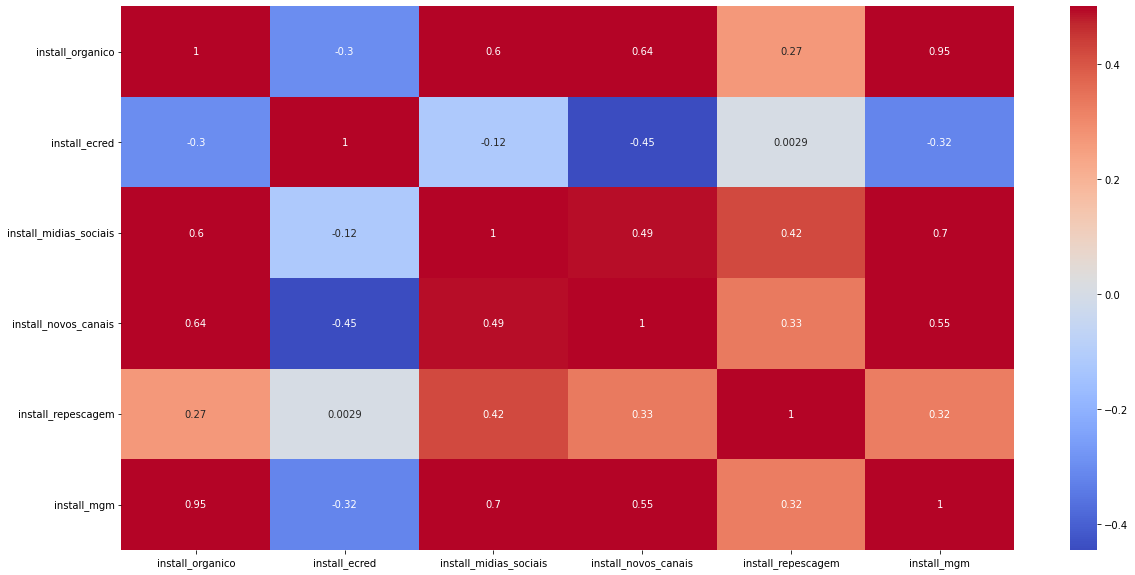

In [22]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(df.drop(id_columns, axis=1).corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

<Figure size 1440x720 with 0 Axes>

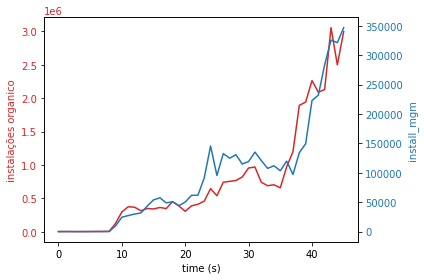

In [23]:
plt.figure(figsize=(20,10))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('instalações organico', color=color)
ax1.plot(df['install_organico'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('install_mgm', color=color)  # we already handled the x-label with ax1
ax2.plot(df['install_mgm'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [24]:
df.dtypes

mes_instalacao            datetime64[ns]
install_organico                   int64
install_ecred                      int64
install_midias_sociais             int64
install_novos_canais               int64
install_repescagem                 int64
install_mgm                        int64
dtype: object


Criando sazonais

In [25]:
#from datetime import datetime

df['mes_instalacao_dt'] = pd.to_datetime(df['mes_instalacao'])
df['ano'] = df['mes_instalacao_dt'].map(lambda x: x.strftime('%Y'))
df['mes'] = df['mes_instalacao_dt'].map(lambda x: x.strftime('%m'))

In [26]:
df.head()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm,mes_instalacao_dt,ano,mes
0,2020-01-01,3263,0,0,0,42,92,2020-01-01,2020,01
1,2020-02-01,4186,0,0,0,85,97,2020-02-01,2020,02
2,2020-03-01,3996,0,0,0,31,74,2020-03-01,2020,03
3,2020-04-01,2950,0,0,0,14,50,2020-04-01,2020,04
4,2020-05-01,3620,0,0,0,13,78,2020-05-01,2020,05


Transformação vars

In [27]:

df['ln_install_organico'] = np.log(df['install_organico'])
df['ln_install_midias_sociais'] = np.log(df['install_midias_sociais'])
df['ln_install_novos_canais'] = np.log(df['install_novos_canais'])
df['ln_install_mgm'] = np.log(df['install_mgm'])

/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Tratando missings

In [28]:
for column in df.columns:
    df[column].fillna(0, inplace = True)

In [29]:
df = df.replace([np.nan, -np.inf], 0)

Text(0.5, 1.0, 'Instalaçoes organico em log')

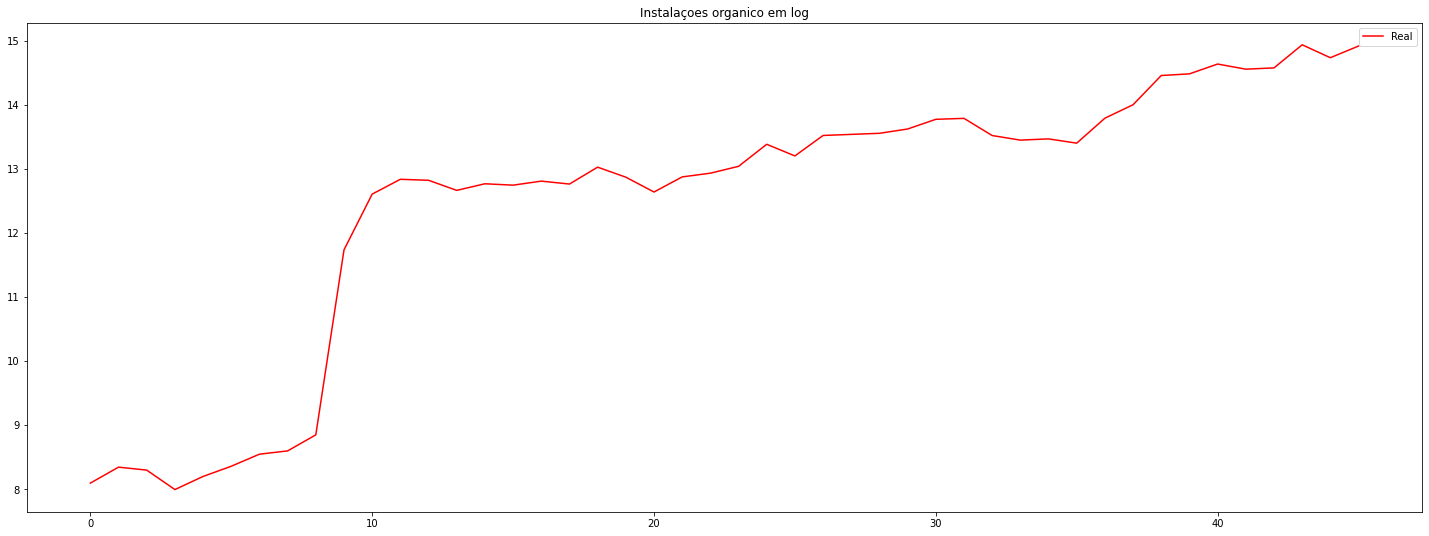

In [30]:
plt.figure(figsize=(25,9))
plt.plot(df['ln_install_organico'], color = 'red', label = 'Real')
plt.legend()
plt.title('Instalaçoes organico em log')

Text(0.5, 1.0, 'Instalaçoes MGM em log')

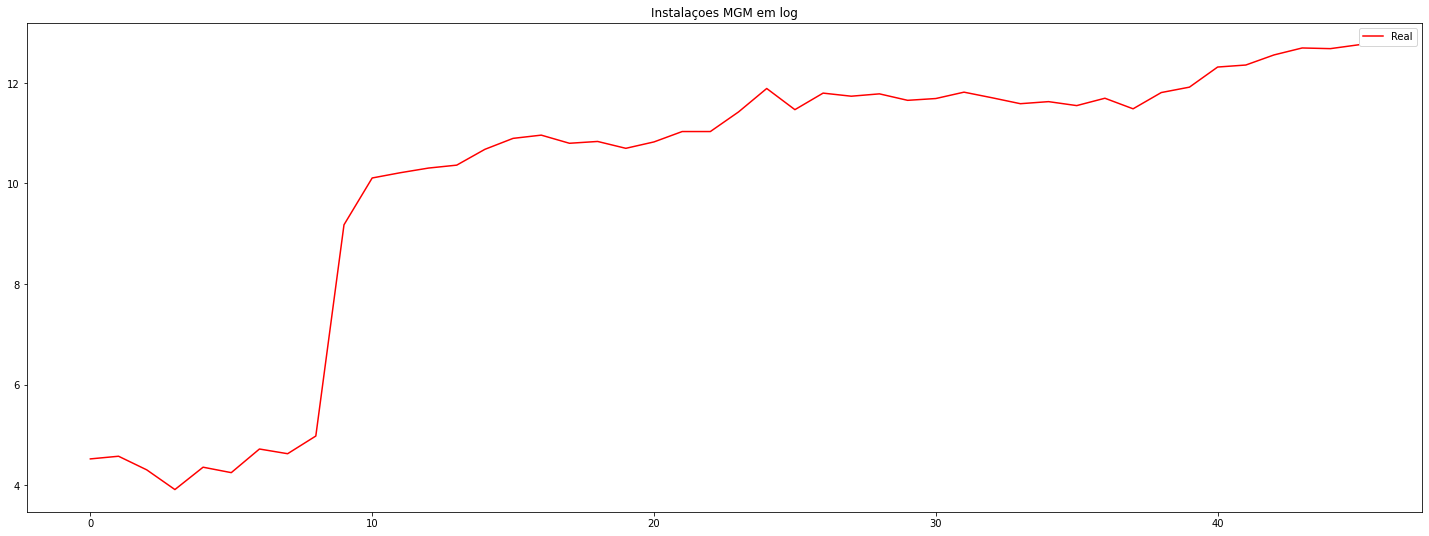

In [31]:
plt.figure(figsize=(25,9))
plt.plot(df['ln_install_mgm'], color = 'red', label = 'Real')
plt.legend()
plt.title('Instalaçoes MGM em log')

### Primeiro teste modelo

In [33]:
formula_text = ("""
    ln_install_organico ~ 
    ln_install_mgm + 
    ln_install_novos_canais + 
    ln_install_midias_sociais +
    C(ano) + 
    C(mes)
        
    """)

In [34]:
model = smf.ols(formula = formula_text, data = df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_install_organico   R-squared:                       0.996
Model:                             OLS   Adj. R-squared:                  0.994
Method:                  Least Squares   F-statistic:                     448.5
Date:                 Thu, 21 Dec 2023   Prob (F-statistic):           1.46e-29
Time:                         09:59:05   Log-Likelihood:                 28.739
No. Observations:                   46   AIC:                            -21.48
Df Residuals:                       28   BIC:                             11.44
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [35]:
formula_text = ("""
    ln_install_organico ~ 
    C(ano) + 
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_install_organico   R-squared:                       0.878
Model:                             OLS   Adj. R-squared:                  0.823
Method:                  Least Squares   F-statistic:                     15.95
Date:                 Thu, 21 Dec 2023   Prob (F-statistic):           2.09e-10
Time:                         09:59:12   Log-Likelihood:                -51.896
No. Observations:                   46   AIC:                             133.8
Df Residuals:                       31   BIC:                             161.2
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.7758      0.5

Média móvel

In [49]:
#df['ma_ln_install_mgm'] = np.log(df['install_mgm'].rolling(2).mean())


In [51]:
# """ """ formula_text = ("""
    
#     ln_install_organico ~ 
#     ln_install_mgm + 
#     ln_install_novos_canais +
#     ma_ln_install_mgm +
#     ln_install_midias_sociais +
#     C(ano) + 
#     C(mes)
        
#     """)

# model = smf.ols(formula = formula_text, data = df).fit()
# print(model.summary()) """ """

                             OLS Regression Results                            
Dep. Variable:     ln_install_organico   R-squared:                       0.986
Model:                             OLS   Adj. R-squared:                  0.976
Method:                  Least Squares   F-statistic:                     105.7
Date:                 Mon, 18 Dec 2023   Prob (F-statistic):           5.20e-21
Time:                         11:05:48   Log-Likelihood:                 13.848
No. Observations:                   47   AIC:                             10.30
Df Residuals:                       28   BIC:                             45.46
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [36]:
prediction = np.exp(model.predict(df))
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df['install_organico']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  62.19562642692259


### Variáveis macroeconomicas

In [58]:
# Importa as bibliotecas
#!pip install python-bcb


     |████████████████████████████████| 71 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 4.4 MB/s eta 0:00:011
     |████████████████████████████████| 85 kB 3.5 MB/s  eta 0:00:01
ERROR: awswrangler 2.19.0 has requirement pandas!=1.5.0,<2.0.0,<=1.5.1,>=1.2.0, but you'll have pandas 1.5.3 which is incompatible.
ERROR: texthero 1.1.0 has requirement spacy<3.0.0, but you'll have spacy 3.6.0 which is incompatible.
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.3
    Uninstalling pandas-1.4.3:
      Successfully uninstalled pandas-1.4.3


In [37]:
from bcb import sgs

# Busca a série da SELIC no SGS
#selic = sgs.get({'selic':432}, start = '2020-01-01')

In [40]:
#ifl_month = sgs.get({'ipca': 433,
#             'igp-m': 189}, start = '2020-01-01')

# Transforma a frequência da data em mensal
#ifl_month.index = ifl_month.index.to_period('M')

In [41]:
#ifl_month = ifl_month.reset_index()
#ifl_month.to_csv('ifl_month')

In [43]:
ifl_month = pd.read_csv('ifl_month.csv')
ifl_month['ipca'] = ifl_month['ipca'].str.replace(',', '.').astype('float')
ifl_month = ifl_month.rename(columns={'igp-m' : 'igpm'})
ifl_month['igpm'] = ifl_month['igpm'].str.replace(',', '.').astype('float')
ifl_month['mes_instalacao'] = ifl_month['Date'].astype('string') + '-01'

In [ ]:

#ifl_month

,Date,ipca,igp-m,mes_instalacao
0,2020-01,0.21,0.48,2020-01-01
1,2020-02,0.25,-0.04,2020-02-01
2,2020-03,0.07,1.24,2020-03-01
3,2020-04,-0.31,0.80,2020-04-01
4,2020-05,-0.38,0.28,2020-05-01
5,2020-06,0.26,1.56,2020-06-01
6,2020-07,0.36,2.23,2020-07-01
7,2020-08,0.24,2.74,2020-08-01
8,2020-09,0.64,4.34,2020-09-01
9,2020-10,0.86,3.23,2020-10-01


In [46]:
ifl_month['mes_instalacao'] = pd.to_datetime(ifl_month['mes_instalacao'])
df = df.join(ifl_month.set_index('mes_instalacao'), on = 'mes_instalacao', how = 'left')

In [47]:
df.head()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm,mes_instalacao_dt,ano,mes,ln_install_organico,ln_install_midias_sociais,ln_install_novos_canais,ln_install_mgm,Date,ipca,igpm
0,2020-01-01,3263,0,0,0,42,92,2020-01-01,2020,01,8.090402,0.0,0.0,4.521789,2020-01,0.21,0.48
1,2020-02-01,4186,0,0,0,85,97,2020-02-01,2020,02,8.339501,0.0,0.0,4.574711,2020-02,0.25,-0.04
2,2020-03-01,3996,0,0,0,31,74,2020-03-01,2020,03,8.293049,0.0,0.0,4.304065,2020-03,0.07,1.24
3,2020-04-01,2950,0,0,0,14,50,2020-04-01,2020,04,7.989560,0.0,0.0,3.912023,2020-04,-0.31,0.80
4,2020-05-01,3620,0,0,0,13,78,2020-05-01,2020,05,8.194229,0.0,0.0,4.356709,2020-05,-0.38,0.28


### Gráfico installs organico x inflação

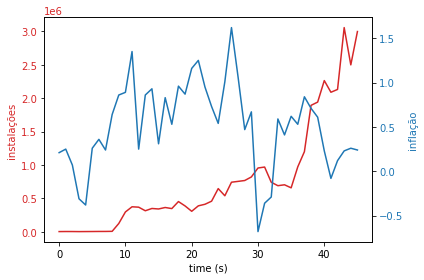

In [48]:

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('instalações', color=color)
ax1.plot(df['install_organico'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('inflação', color=color)  # we already handled the x-label with ax1
ax2.plot(df['ipca'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [49]:
df.columns

Index(['mes_instalacao', 'install_organico', 'install_ecred',
       'install_midias_sociais', 'install_novos_canais', 'install_repescagem',
       'install_mgm', 'mes_instalacao_dt', 'ano', 'mes', 'ln_install_organico',
       'ln_install_midias_sociais', 'ln_install_novos_canais',
       'ln_install_mgm', 'Date', 'ipca', 'igpm'],
      dtype='object')

### Modelo com inflação

O modelo se mostrou melhor especificado, e com menor autocorrelação serial

In [50]:
formula_text = ("""
    ln_install_organico ~ 
    ln_install_mgm + 
    ln_install_novos_canais + 
    ln_install_midias_sociais +
    ipca +
    igpm +
    C(ano) + 
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_install_organico   R-squared:                       0.996
Model:                             OLS   Adj. R-squared:                  0.994
Method:                  Least Squares   F-statistic:                     375.1
Date:                 Thu, 21 Dec 2023   Prob (F-statistic):           6.04e-27
Time:                         10:07:55   Log-Likelihood:                 28.886
No. Observations:                   46   AIC:                            -17.77
Df Residuals:                       26   BIC:                             18.80
Df Model:                           19                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [51]:
prediction = np.exp(model.predict(df))
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df['install_organico']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  9.854776114439032


Text(0.5, 1.0, 'Instalaçoes Organico - Real x Projetado')

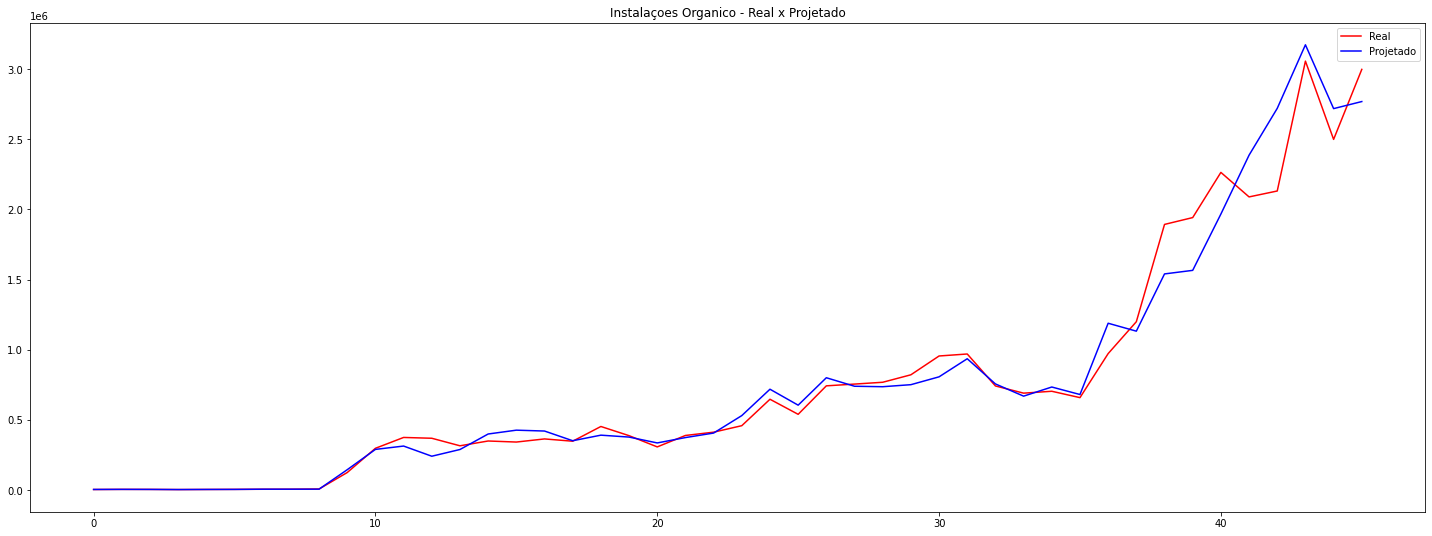

In [52]:
plt.figure(figsize=(25,9))
plt.plot(projecao_final['real'], color = 'red', label = 'Real')
plt.plot(projecao_final['prediction_test'], color = 'blue', label = 'Projetado')
plt.legend()
plt.title('Instalaçoes Organico - Real x Projetado')

## Observando mais variáveis 

### Houve efeito Covid?

Text(0.5, 1.0, 'Instalações organico')

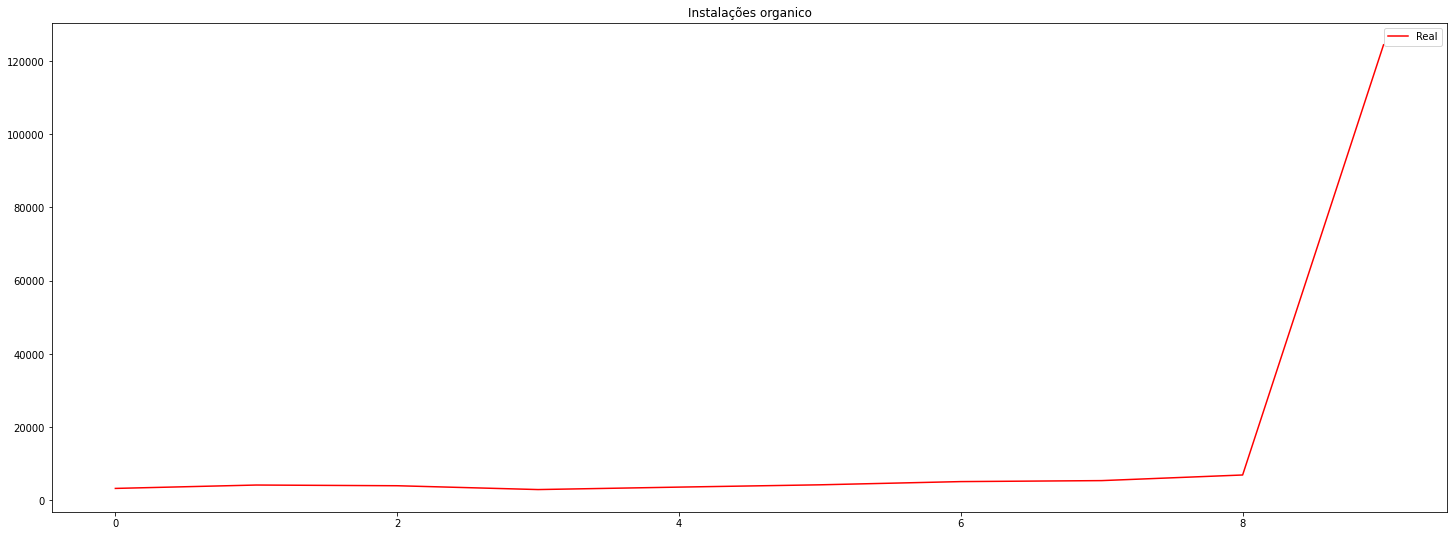

In [53]:
plt.figure(figsize=(25,9))
plt.plot(df['install_organico'].head(10), color = 'red', label = 'Real')
plt.legend()
plt.title('Instalações organico')

### Base de eventos

In [54]:
query_eventos = '''
select 
concat(substring(cast(dt_date as varchar), 1, 7), '-01') as dt_mes_evento
, count(case when ds_day_of_week = 'Dom' then dt_date end) as qtos_domingos
, max(case when ds_holiday_or_event = 'Carnaval' then 1 end) as flag_carnaval
, sum(is_holiday) as qt_feriados
, sum(is_holiday_or_event) as qt_feriados_ou_comercial
from customer_curated_zone.ca_dict_events
where dt_date >= date('2020-01-01')
group by 1
order by 1

'''


In [55]:
eventos = ac.df_athena('flavia-costa', query_eventos)

In [56]:
for column in eventos.columns:
    eventos[column].fillna(0, inplace = True)

In [57]:
eventos = eventos.rename(columns = {'dt_mes_evento': 'mes_instalacao'})

In [58]:
eventos.head()

,mes_instalacao,qtos_domingos,flag_carnaval,qt_feriados,qt_feriados_ou_comercial
0,2020-01-01,4,0.0,1,1
1,2020-02-01,4,1.0,2,2
2,2020-03-01,5,1.0,0,1
3,2020-04-01,4,0.0,2,3
4,2020-05-01,5,0.0,1,2


In [60]:
eventos['mes_instalacao'] = pd.to_datetime(eventos['mes_instalacao'])
df = df.join(eventos.set_index('mes_instalacao'), on = 'mes_instalacao', how = 'left')

In [61]:
df.head()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm,mes_instalacao_dt,ano,mes,...,ln_install_midias_sociais,ln_install_novos_canais,ln_install_mgm,Date,ipca,igpm,qtos_domingos,flag_carnaval,qt_feriados,qt_feriados_ou_comercial
0,2020-01-01,3263,0,0,0,42,92,2020-01-01,2020,01,...,0.0,0.0,4.521789,2020-01,0.21,0.48,4,0.0,1,1
1,2020-02-01,4186,0,0,0,85,97,2020-02-01,2020,02,...,0.0,0.0,4.574711,2020-02,0.25,-0.04,4,1.0,2,2
2,2020-03-01,3996,0,0,0,31,74,2020-03-01,2020,03,...,0.0,0.0,4.304065,2020-03,0.07,1.24,5,1.0,0,1
3,2020-04-01,2950,0,0,0,14,50,2020-04-01,2020,04,...,0.0,0.0,3.912023,2020-04,-0.31,0.80,4,0.0,2,3
4,2020-05-01,3620,0,0,0,13,78,2020-05-01,2020,05,...,0.0,0.0,4.356709,2020-05,-0.38,0.28,5,0.0,1,2


In [62]:
df['flag_will'] = np.where((df['mes_instalacao_dt'] >= '2020-11-01'), 1, 0 )

In [63]:
df['flag_will'].value_counts()

1    36
0    10
Name: flag_will, dtype: int64

In [64]:
df['flag_covid'] = np.where((df['mes_instalacao_dt'] >= '2020-03-01') &
   (df['mes_instalacao_dt'] < '2020-06-01'), 1, 0 )

df['flag_covid'].value_counts()

0    43
1     3
Name: flag_covid, dtype: int64

### Modelo com demais sazonais

In [65]:
formula_text = ("""
    ln_install_organico ~ 
    ln_install_mgm + 
    ln_install_novos_canais + 
    ln_install_midias_sociais +
    flag_will +
    flag_covid +
    qtos_domingos	+
    flag_carnaval + 
    qt_feriados	+ 
    qt_feriados_ou_comercial +        
    ipca +
    igpm +
    C(ano) + 
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_install_organico   R-squared:                       0.997
Model:                             OLS   Adj. R-squared:                  0.994
Method:                  Least Squares   F-statistic:                     294.6
Date:                 Thu, 21 Dec 2023   Prob (F-statistic):           1.37e-21
Time:                         10:11:03   Log-Likelihood:                 33.602
No. Observations:                   46   AIC:                            -17.20
Df Residuals:                       21   BIC:                             28.51
Df Model:                           24                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

##### Exporta coeficientes

In [70]:
pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].to_csv('coeficients_install.csv')

##### Mape do modelo final e gráfico real x projetado

In [66]:
prediction = np.exp(model.predict(df))
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df['install_organico']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  8.74616934562793


Text(0.5, 1.0, 'Instalaçoes Organico - Real x Projetado')

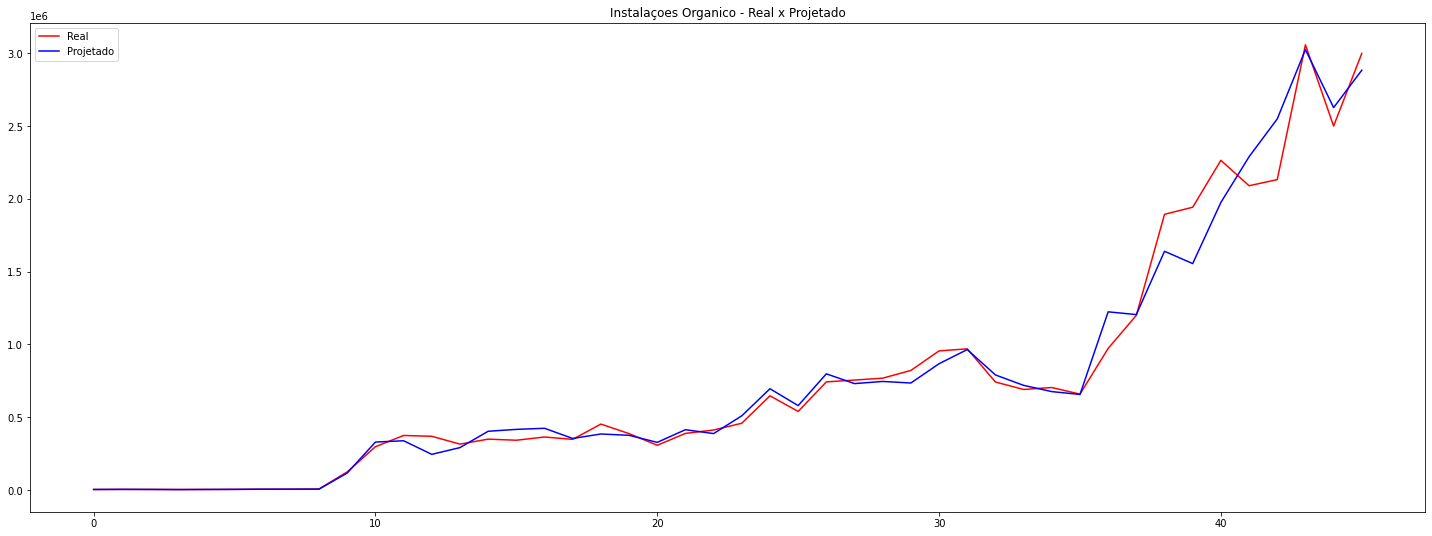

In [67]:
plt.figure(figsize=(25,9))
plt.plot(projecao_final['real'], color = 'red', label = 'Real')
plt.plot(projecao_final['prediction_test'], color = 'blue', label = 'Projetado')
plt.legend()
plt.title('Instalaçoes Organico - Real x Projetado')

In [68]:
df.to_csv('dados_actual.csv', index = False)

### Testando Prophet 

In [150]:
!pip install prophet

     |████████████████████████████████| 14.4 MB 342 kB/s eta 0:00:01
     |████████████████████████████████| 93 kB 2.1 MB/s  eta 0:00:01
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [71]:
query_diaria = """

select cast(a.install_time as date) as dt_instalacao,
count(distinct case when b.nm_media_source_appsflyer_group_big = 'organico' then a.appsflyer_id end) as install_organico,
count(distinct case when b.nm_media_source_appsflyer_group_big = 'midias sociais' then a.appsflyer_id end) as install_midias_sociais,
count(distinct case when b.nm_media_source_appsflyer_group_big = 'novos canais' then a.appsflyer_id end) as install_novos_canais,
count(distinct case when b.nm_media_source_appsflyer_group_big = 'mgm' then a.appsflyer_id end) as install_mgm
from growth_curated_zone.appsflyer_base_atribuicao a
left join processed_zone_api_cac_planilha.grupo_midia_mkt b
on lower(a.media_source) = lower(b.nm_media_source_appsflyer)
where row_install_attrib = 1
and a.install_time >= date('2020-01-01')
and a.install_time < date('2023-11-01')
group by 1
order by 1

"""

In [72]:
df2 = ac.df_athena('flavia-costa', query_diaria)

In [88]:
df2.tail()

,dt_instalacao,install_organico,install_midias_sociais,install_novos_canais,install_mgm,ln_novos_canais
1395,2023-10-27,93779,12959,5091,14171,8.535230
1396,2023-10-28,89743,12101,3975,9377,8.287780
1397,2023-10-29,91532,11673,4666,8515,8.448057
1398,2023-10-30,99913,14451,5630,13690,8.635865
1399,2023-10-31,98706,14603,7708,12163,8.950014


In [73]:
df2.columns  

Index(['dt_instalacao', 'install_organico', 'install_midias_sociais',
       'install_novos_canais', 'install_mgm'],
      dtype='object')

In [17]:
df2.dtypes

dt_instalacao             object
install_organico           int64
install_midias_sociais     int64
install_novos_canais       int64
install_mgm                int64
dtype: object

In [75]:
from prophet import Prophet

In [89]:
features_previsao = ['install_organico', 'install_mgm', 'install_novos_canais', 'install_midias_sociais']
forecast_final = []

for i in features_previsao:
    m = Prophet()
    df_temp = df2[['dt_instalacao', i]]
    df_temp = df_temp.rename(columns={'dt_instalacao': 'ds', i: 'y'})
    m.fit(df_temp)
    future = m.make_future_dataframe(periods=500)
    forecast = m.predict(future)
    forecast['feature'] = i
    forecast_final = forecast.append(forecast_final)


11:39:33 - cmdstanpy - INFO - Chain [1] start processing
11:39:33 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_1492811/1844933135.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_final = forecast.append(forecast_final)
11:39:38 - cmdstanpy - INFO - Chain [1] start processing
11:39:38 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_1492811/1844933135.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_final = forecast.append(forecast_final)
11:39:40 - cmdstanpy - INFO - Chain [1] start processing
11:39:40 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_1492811/1844933135.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_final = forecast.append(fo

In [90]:
forecast_final.to_csv('base_prophet.csv')

### Organico

10:46:37 - cmdstanpy - INFO - Chain [1] start processing
10:46:38 - cmdstanpy - INFO - Chain [1] done processing


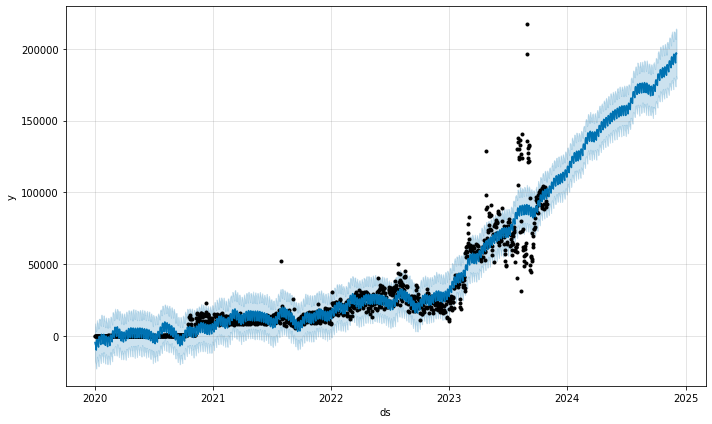

In [78]:
m = Prophet()
df_temp = df2[['dt_instalacao', 'install_organico']]
df_temp = df_temp.rename(columns={'dt_instalacao': 'ds', 'install_organico': 'y'})
m.fit(df_temp)
future = m.make_future_dataframe(periods=400)
forecast = m.predict(future)
fig1 = m.plot(forecast)

### MGM

10:47:22 - cmdstanpy - INFO - Chain [1] start processing
10:47:22 - cmdstanpy - INFO - Chain [1] done processing


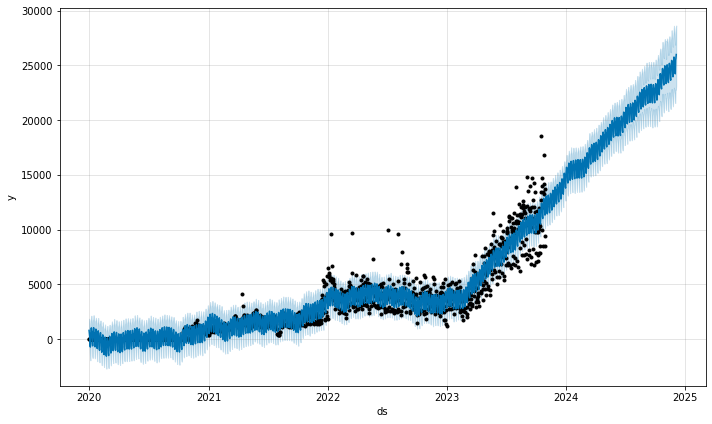

In [81]:
m = Prophet()
df_temp = df2[['dt_instalacao', 'install_mgm']]
df_temp = df_temp.rename(columns={'dt_instalacao': 'ds', 'install_mgm': 'y'})
m.fit(df_temp)
future = m.make_future_dataframe(periods=400)
forecast = m.predict(future)
fig1 = m.plot(forecast)

### novos canais

/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
10:47:30 - cmdstanpy - INFO - Chain [1] start processing
10:47:30 - cmdstanpy - INFO - Chain [1] done processing


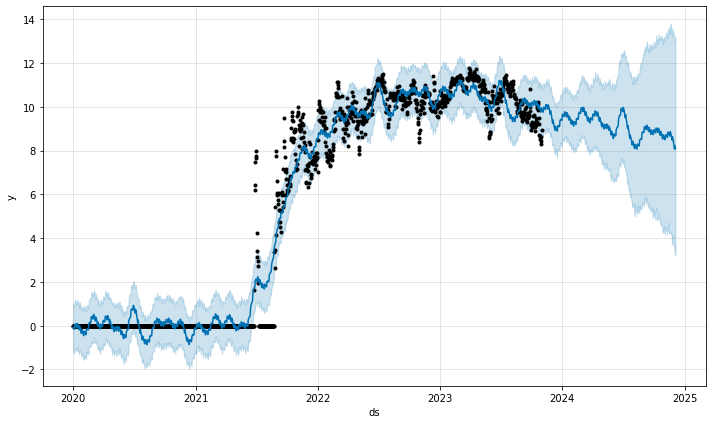

In [82]:
m = Prophet()
df2['ln_novos_canais'] = np.log(df2['install_novos_canais'])
df2 = df2.replace([np.nan, -np.inf], 0)
df_temp = df2[['dt_instalacao', 'ln_novos_canais']]
df_temp = df_temp.rename(columns={'dt_instalacao': 'ds', 'ln_novos_canais': 'y'})
m.fit(df_temp)
future = m.make_future_dataframe(periods=400)
forecast = m.predict(future)
fig1 = m.plot(forecast)

### Mídias Sociais

11:11:20 - cmdstanpy - INFO - Chain [1] start processing
11:11:20 - cmdstanpy - INFO - Chain [1] done processing


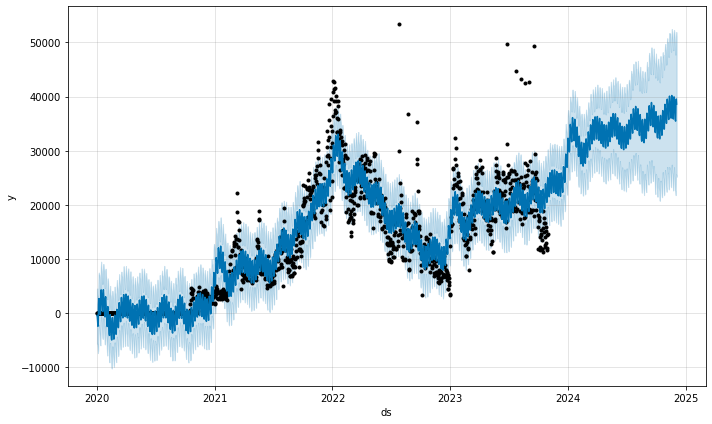

In [83]:
m = Prophet()
df_temp = df2[['dt_instalacao', 'install_midias_sociais']]
df_temp = df_temp.rename(columns={'dt_instalacao': 'ds', 'install_midias_sociais': 'y'})
m.fit(df_temp)
future = m.make_future_dataframe(periods=400)
forecast = m.predict(future)
fig1 = m.plot(forecast)

### Modelando relação entre instalações e propostas - orgânico

In [96]:
query_prop = """

select 
date_trunc('month', a.dt_receivement_engine) as mes_instalacao
, count(distinct case when b.nm_media_source_appsflyer_group_mkt = 'organico' then a.id_proposal end) as propostas_organico
, count(distinct case when b.nm_media_source_appsflyer_group_mkt = 'mgm' then a.id_proposal end) as propostas_mgm
, count(distinct case when b.nm_media_source_group = 'mídias sociais' then a.id_proposal end) as propostas_midias_sociais
from growth_curated_zone.proposal_analysis a
left join growth_curated_zone.proposal_media b
on a.id_proposal = b.id_proposal
where date(a.dt_receivement_engine) >= date'2022-01-01'
and date(a.dt_receivement_engine) < date'2023-12-01'
group by 1
order by 1


"""

In [97]:
propostas = ac.df_athena('flavia-costa', query_prop)

In [98]:
propostas.head()

,mes_instalacao,propostas_organico,propostas_mgm,propostas_midias_sociais
0,2022-01-01,286926,112984,749521
1,2022-02-01,217092,73581,389464
2,2022-03-01,273548,94922,558925
3,2022-04-01,312550,90067,617239
4,2022-05-01,301742,96131,482289


In [99]:
propostas.tail(15)

,mes_instalacao,propostas_organico,propostas_mgm,propostas_midias_sociais
8,2022-09-01,278009,91289,359075
9,2022-10-01,222226,76597,284197
10,2022-11-01,250108,80569,326636
11,2022-12-01,214583,73531,240355
12,2023-01-01,257385,89963,454056
13,2023-02-01,173342,71483,316661
14,2023-03-01,200256,96570,360831
15,2023-04-01,182470,107974,350724
16,2023-05-01,280770,159936,397940
17,2023-06-01,334396,175403,478091


In [134]:
df3 = propostas.join(df[['mes_instalacao', 'install_organico', 'install_mgm', 'install_midias_sociais', 'install_novos_canais']].set_index('mes_instalacao'), on = 'mes_instalacao', how = 'left')

<Figure size 1440x720 with 0 Axes>

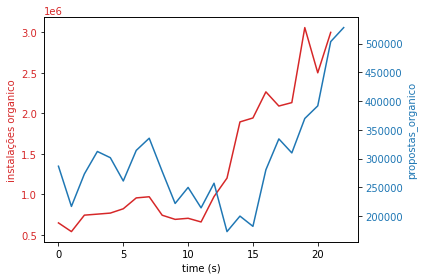

In [101]:
plt.figure(figsize=(20,10))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('instalações organico', color=color)
ax1.plot(df3['install_organico'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('propostas_organico', color=color)  # we already handled the x-label with ax1
ax2.plot(df3['propostas_organico'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

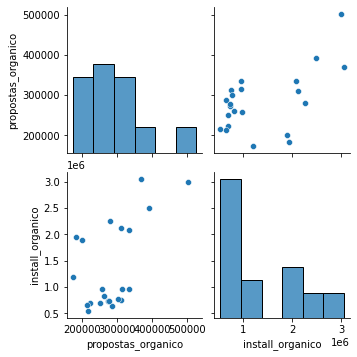

In [102]:
sns.pairplot(df3[['propostas_organico', 'install_organico']])
plt.show()

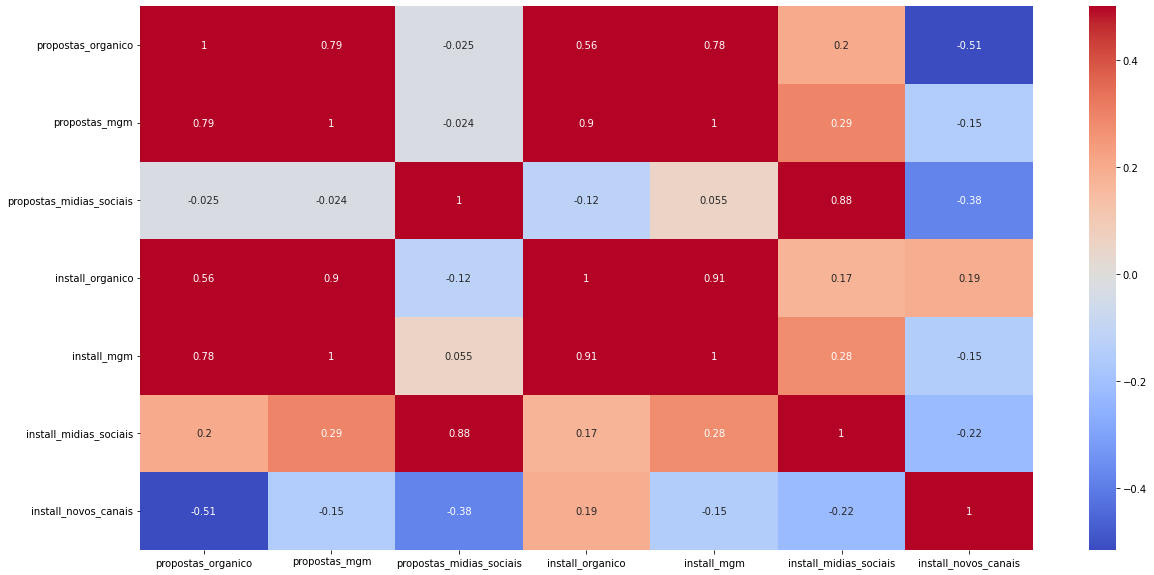

In [135]:
plt.figure(figsize=(20,10))
sns.heatmap(df3.corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [136]:
df3['ln_install_organico'] = np.log(df3['install_organico'])
df3['ln_install_mgm'] = np.log(df3['install_mgm'])
df3['ln_install_midias_sociais'] = np.log(df3['install_midias_sociais'])
df3['ln_install_novos_canais'] = np.log(df3['install_novos_canais'])

df3['ln_propostas_organico'] = np.log(df3['propostas_organico'])
df3['ln_propostas_mgm'] = np.log(df3['propostas_mgm'])
df3['ln_propostas_midias_sociais'] = np.log(df3['propostas_midias_sociais'])

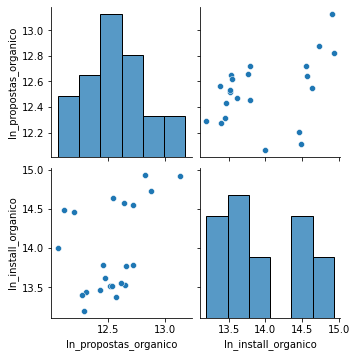

In [105]:
sns.pairplot(df3[['ln_propostas_organico', 'ln_install_organico']])
plt.show()

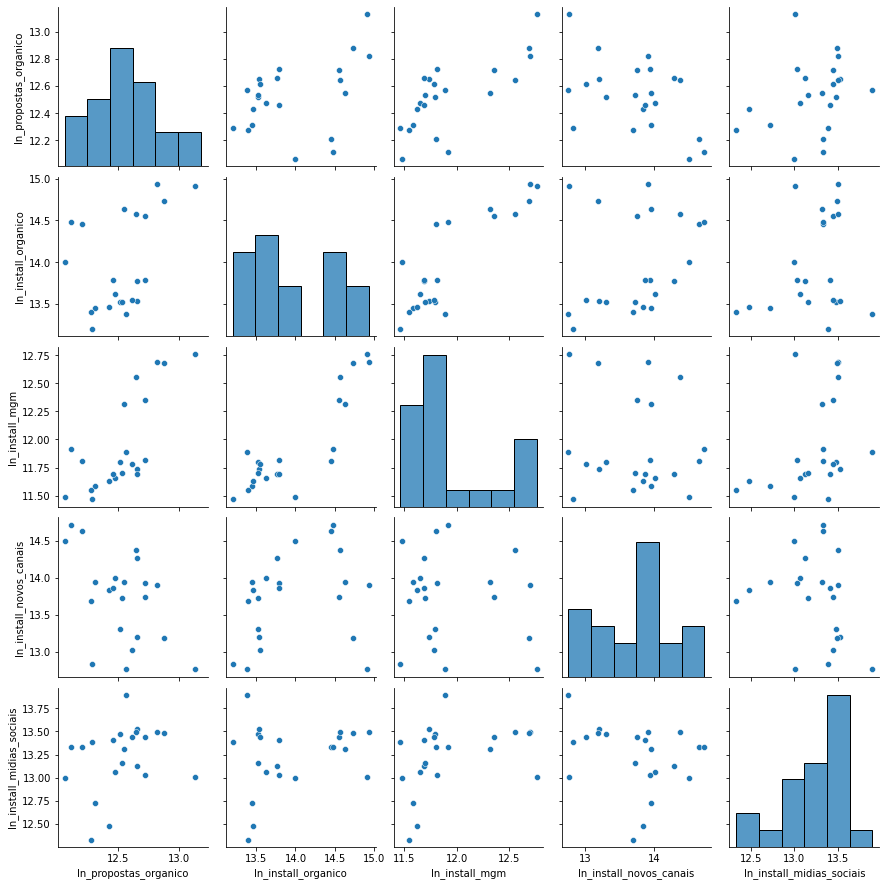

In [137]:
sns.pairplot(df3[['ln_propostas_organico', 'ln_install_organico', 'ln_install_mgm', 'ln_install_novos_canais', 'ln_install_midias_sociais']])
plt.show()

In [111]:
formula_text = ("""
    ln_propostas_organico ~ 
    ln_install_organico
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_propostas_organico   R-squared:                       0.174
Model:                               OLS   Adj. R-squared:                  0.132
Method:                    Least Squares   F-statistic:                     4.206
Date:                   Thu, 21 Dec 2023   Prob (F-statistic):             0.0536
Time:                           12:04:36   Log-Likelihood:                 1.3684
No. Observations:                     22   AIC:                             1.263
Df Residuals:                         20   BIC:                             3.445
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

In [145]:
df3['mes_instalacao_dt'] = pd.to_datetime(df3['mes_instalacao'])
df3['ano'] = df3['mes_instalacao_dt'].map(lambda x: x.strftime('%Y'))
df3['mes'] = df3['mes_instalacao_dt'].map(lambda x: x.strftime('%m'))

In [113]:
formula_text = ("""
    ln_propostas_organico ~ 
    ln_install_organico +
    C(ano) +
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_propostas_organico   R-squared:                       0.715
Model:                               OLS   Adj. R-squared:                  0.253
Method:                    Least Squares   F-statistic:                     1.548
Date:                   Thu, 21 Dec 2023   Prob (F-statistic):              0.272
Time:                           12:04:46   Log-Likelihood:                 13.096
No. Observations:                     22   AIC:                             1.809
Df Residuals:                          8   BIC:                             17.08
Df Model:                             13                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

In [143]:
df3 = df3.join(eventos.set_index('mes_instalacao'), on = 'mes_instalacao', how = 'left')

In [115]:
formula_text = ("""
    ln_propostas_organico ~ 
    ln_install_organico + 
    qtos_domingos	+
    flag_carnaval + 
    qt_feriados	+ 
    qt_feriados_ou_comercial + 
    C(ano) + 
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_propostas_organico   R-squared:                       0.785
Model:                               OLS   Adj. R-squared:                  0.095
Method:                    Least Squares   F-statistic:                     1.138
Date:                   Thu, 21 Dec 2023   Prob (F-statistic):              0.483
Time:                           12:04:52   Log-Likelihood:                 16.154
No. Observations:                     22   AIC:                             1.692
Df Residuals:                          5   BIC:                             20.24
Df Model:                             16                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

#### Testando modelagem do percentual

In [138]:
df3['perc_propostas'] = df3['propostas_organico'] / df3['install_organico']

Text(0.5, 1.0, 'Percentual de propostas')

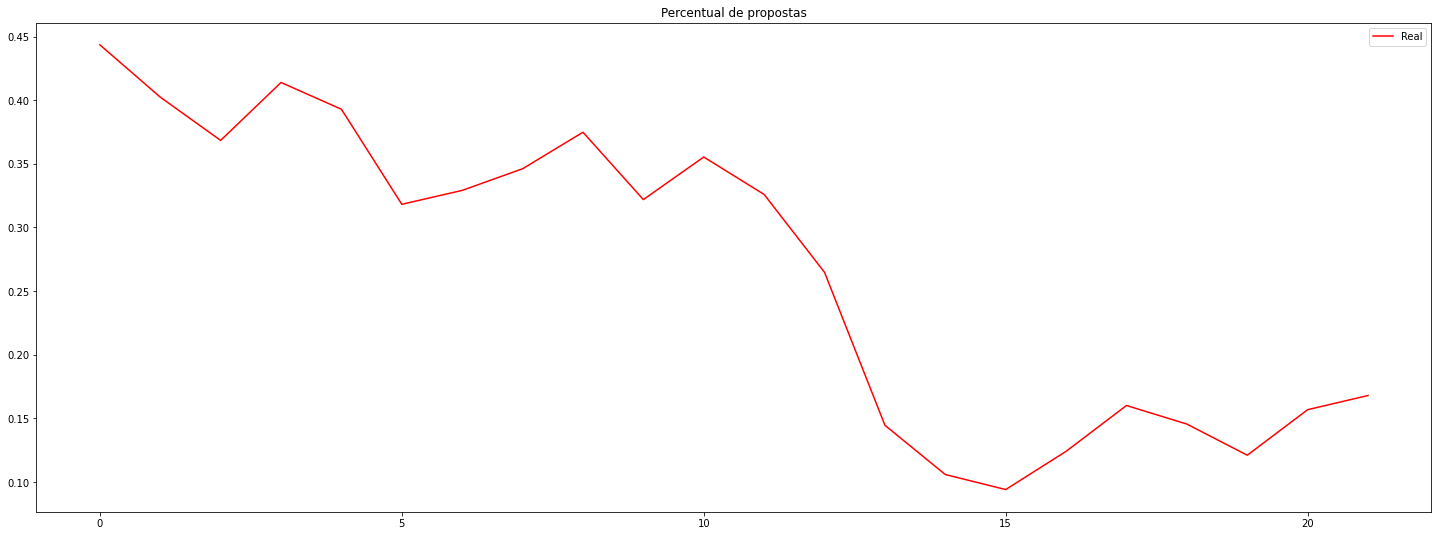

In [117]:
plt.figure(figsize=(25,9))
plt.plot(df3['perc_propostas'], color = 'red', label = 'Real')
plt.legend()
plt.title('Percentual de propostas')

In [118]:
formula_text = ("""
    perc_propostas ~
    qtos_domingos	+
    flag_carnaval + 
    qt_feriados	+ 
    qt_feriados_ou_comercial + 
    C(ano) +
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         perc_propostas   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     10.42
Date:                Thu, 21 Dec 2023   Prob (F-statistic):            0.00426
Time:                        12:05:10   Log-Likelihood:                 52.415
No. Observations:                  22   AIC:                            -72.83
Df Residuals:                       6   BIC:                            -55.37
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [119]:
ifl_month = pd.read_csv('ifl_month.csv')

In [139]:
ifl_month['mes_instalacao'] = pd.to_datetime(ifl_month['mes_instalacao'])
df3 = df3.join(ifl_month.set_index('mes_instalacao'), on = 'mes_instalacao', how = 'left')

In [140]:
df3['ipca'] = df3['ipca'].str.replace(',', '.').astype('float')

<Figure size 1440x720 with 0 Axes>

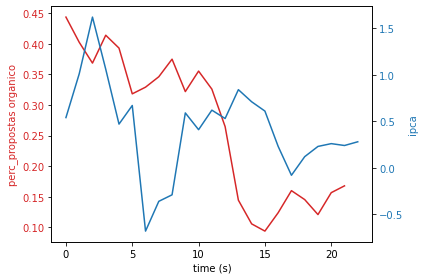

In [141]:
plt.figure(figsize=(20,10))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('perc_propostas organico', color=color)
ax1.plot(df3['perc_propostas'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('ipca', color=color)  # we already handled the x-label with ax1
ax2.plot(df3['ipca'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [124]:
formula_text = ("""
    perc_propostas ~
    qtos_domingos	+
    flag_carnaval + 
    qt_feriados	+ 
    qt_feriados_ou_comercial +
    ipca + 
    C(ano) +
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         perc_propostas   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     8.147
Date:                Thu, 21 Dec 2023   Prob (F-statistic):             0.0147
Time:                        12:06:44   Log-Likelihood:                 52.429
No. Observations:                  22   AIC:                            -70.86
Df Residuals:                       5   BIC:                            -52.31
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [129]:
df3.columns

Index(['mes_instalacao', 'propostas_organico', 'propostas_mgm',
       'propostas_midias_sociais', 'install_organico', 'install_mgm',
       'ln_install_organico', 'ln_propostas_organico', 'ln_propostas_mgm',
       'ln_propostas_midias_sociais', 'mes_instalacao_dt', 'ano', 'mes',
       'qtos_domingos', 'flag_carnaval', 'qt_feriados',
       'qt_feriados_ou_comercial', 'perc_propostas', 'Date', 'ipca', 'igp-m',
       'ln_install_mgm'],
      dtype='object')

In [152]:
df3[['install_mgm', 'ln_install_mgm']].tail(15)

,install_mgm,ln_install_mgm
8,120976.0,11.703347
9,107564.0,11.585841
10,112070.0,11.626879
11,103575.0,11.548051
12,119904.0,11.694447
13,97178.0,11.484300
14,134269.0,11.807601
15,149508.0,11.915105
16,222995.0,12.314905
17,232106.0,12.354949


In [146]:
formula_text = ("""
    perc_propostas ~
    ln_install_mgm +
    ln_install_novos_canais +
    ln_install_midias_sociais +            
    qtos_domingos	+
    flag_carnaval + 
    qt_feriados	+ 
    qt_feriados_ou_comercial +
    C(ano) +
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         perc_propostas   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     28.56
Date:                Thu, 21 Dec 2023   Prob (F-statistic):            0.00909
Time:                        12:18:15   Log-Likelihood:                 72.790
No. Observations:                  22   AIC:                            -107.6
Df Residuals:                       3   BIC:                            -86.85
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [147]:
prediction = model.predict(df3) #sem exp
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df3['perc_propostas']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  2.8078618699356106


Text(0.5, 1.0, 'Percentual de propostas Organico')

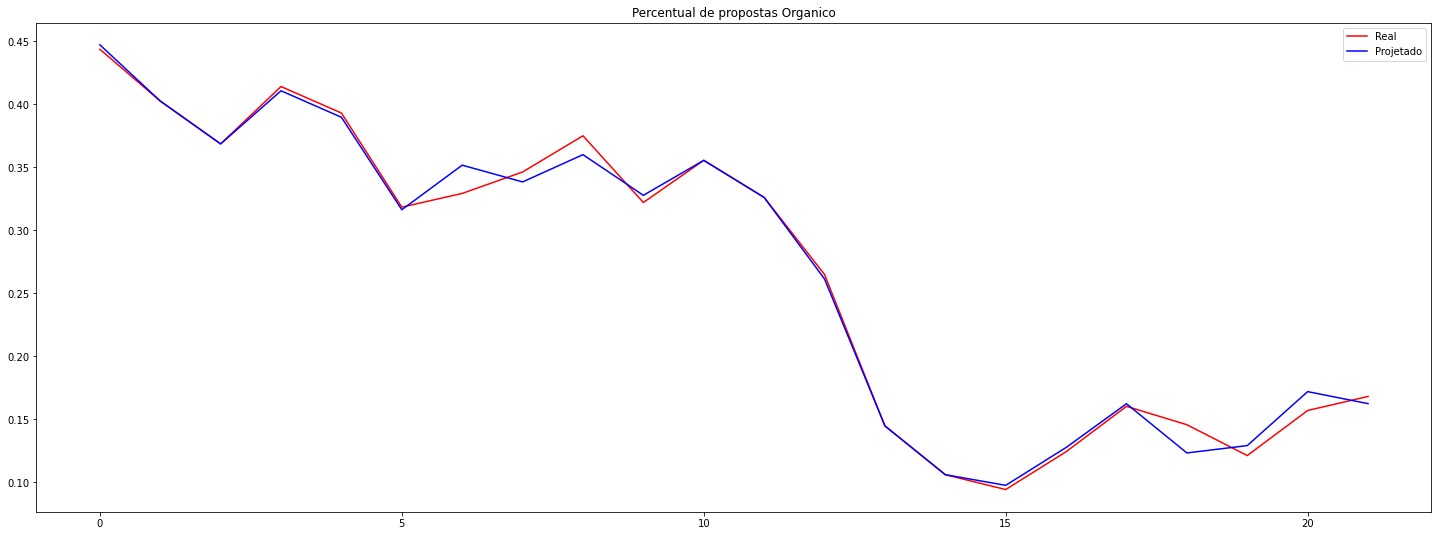

In [148]:
plt.figure(figsize=(25,9))
plt.plot(projecao_final['real'], color = 'red', label = 'Real')
plt.plot(projecao_final['prediction_test'], color = 'blue', label = 'Projetado')
plt.legend()
plt.title('Percentual de propostas Organico')

### Testando o log do percentual de propostas para evitar valores negativos

In [153]:
df3['ln_perc_propostas'] = np.log(df3['perc_propostas'])

In [154]:
formula_text = ("""
    ln_perc_propostas ~
    ln_install_mgm +
    ln_install_novos_canais +
    ln_install_midias_sociais +            
    qtos_domingos	+
    flag_carnaval + 
    qt_feriados	+ 
    qt_feriados_ou_comercial +
    C(ano) +
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      ln_perc_propostas   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     22.58
Date:                Thu, 21 Dec 2023   Prob (F-statistic):             0.0128
Time:                        12:40:00   Log-Likelihood:                 37.792
No. Observations:                  22   AIC:                            -37.58
Df Residuals:                       3   BIC:                            -16.85
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [155]:
prediction = np.exp(model.predict(df3)) #sem exp
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df3['perc_propostas']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  2.84509675760886


Text(0.5, 1.0, 'Percentual de propostas Organico')

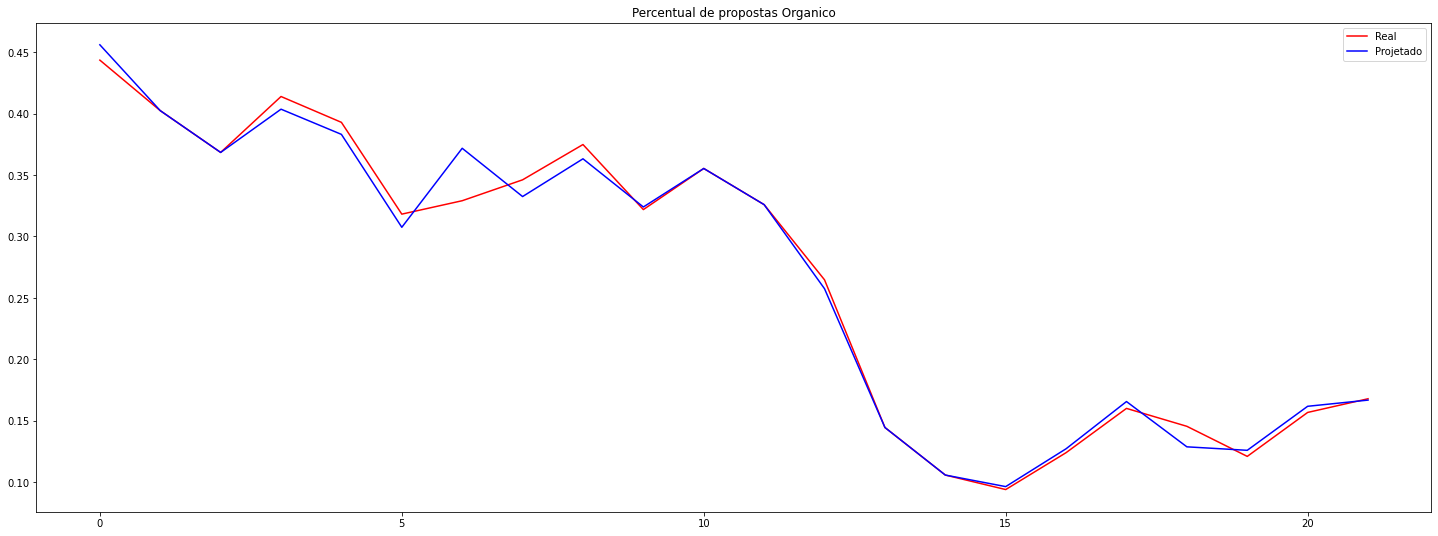

In [156]:
plt.figure(figsize=(25,9))
plt.plot(projecao_final['real'], color = 'red', label = 'Real')
plt.plot(projecao_final['prediction_test'], color = 'blue', label = 'Projetado')
plt.legend()
plt.title('Percentual de propostas Organico')

In [157]:
pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].to_csv('coeficients_proposal.csv')

### teste prophet

12:19:02 - cmdstanpy - INFO - Chain [1] start processing


12:19:02 - cmdstanpy - INFO - Chain [1] done processing


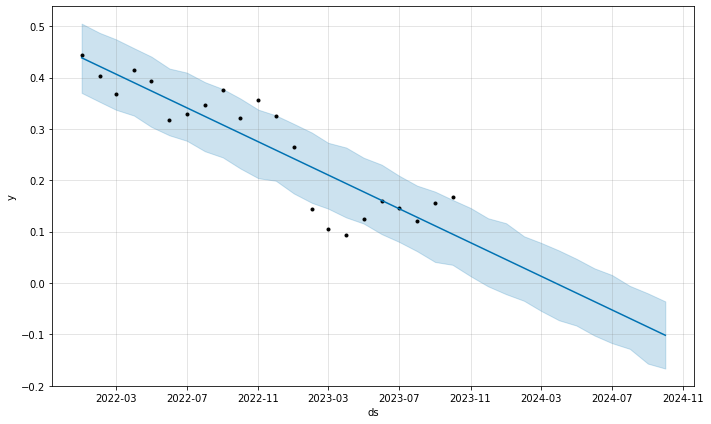

In [150]:
m = Prophet(seasonality_mode='multiplicative')
df_temp = df3[['mes_instalacao', 'perc_propostas']]
df_temp = df_temp.rename(columns={'mes_instalacao': 'ds', 'perc_propostas': 'y'})
m.fit(df_temp)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)
fig1 = m.plot(forecast)